In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

In [2]:

train_dir = os.path.join('./train')
validation_dir = os.path.join('./val')
test_dir = os.path.join('./test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 21998 files belonging to 6 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2442 files belonging to 6 classes.


In [4]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 600 files belonging to 6 classes.


Show the first nine images and labels from the training set:

In [5]:
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Print the true labels
print('True Labels:\n', true_labels)

True Labels:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

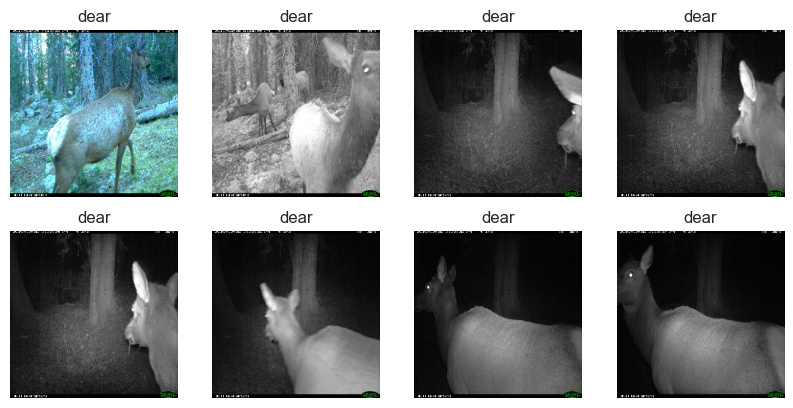

In [6]:
class_labels = ['dear', 'fox','leopard cat','porcupine','sumatran serow', 'wild boar']

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)



In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 77
Number of test batches: 19


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. 

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=None, name=None),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='nearest'),
    
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

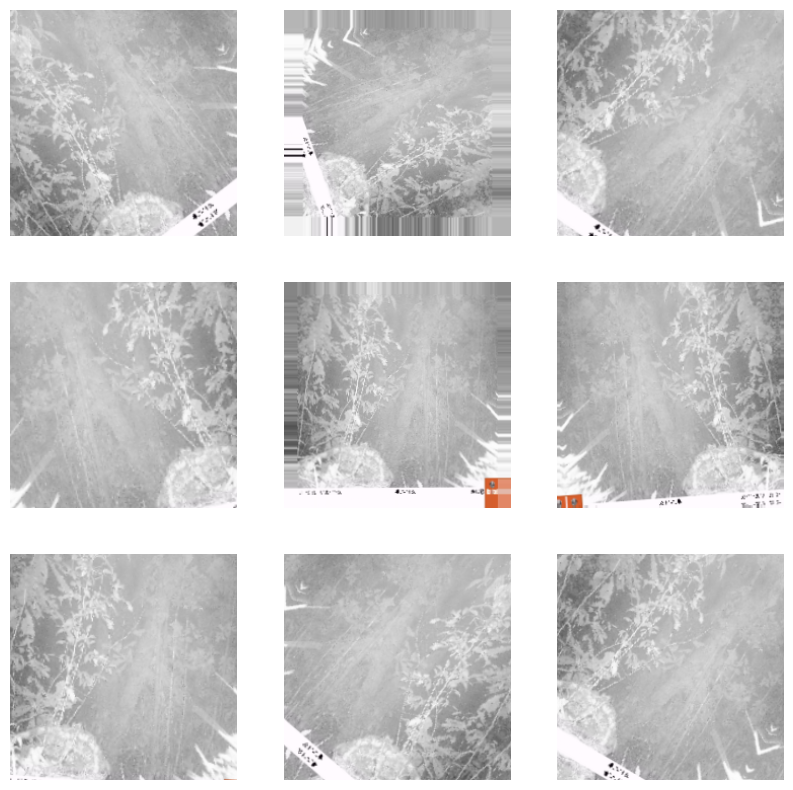

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
tf.keras.backend.clear_session()

In [13]:
# import tensorflow as tf
# from tensorflow.keras.layers import BatchNormalization

# from kerastuner.tuners import RandomSearch
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# def build_model(hp):
#     IMG_SHAPE = IMG_SIZE + (3,)
    
#     # Base MobileNetV2 model
#     base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                    include_top=False,
#                                                    weights='imagenet')
    
#     # Global average pooling layer
#     global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


#     # Input layer
#     inputs = tf.keras.Input(shape=(224, 224, 3))
    
#     # BatchNormalization layer
#     x = BatchNormalization()(inputs)
    
#     # Data augmentation
#     x = data_augmentation(x)
    
#     # Preprocess input
#     x = preprocess_input(x)
    
#     # Base MobileNetV2 model
#     x = base_model(x, training=False)
    
#     # Global average pooling
#     x = global_average_layer(x)
    
#     # Dropout layer with tunable rate
#     dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
#     # Dense prediction layer with L2 regularization
#     l2_reg_strength = hp.Float('l2_reg_strength', min_value=1e-4, max_value=1e-2, sampling='LOG')
#     prediction_layer = tf.keras.layers.Dense(len(class_labels), activation='softmax', name='prediction', 
#                                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg_strength))
#     outputs = prediction_layer(x)
    
#     # Build the model
#     model = tf.keras.Model(inputs, outputs)



#     # Compile the model
#     model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
#                   metrics=['accuracy', 'top_k_categorical_accuracy'], loss='sparse_categorical_crossentropy')
    
#     return model

# # Instantiate the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,  # Adjust the number of trials as needed
#     directory='keras_tuner_dir',
#     project_name='image_classification')

# # Define a callback to stop training early if there's no improvement
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# # Perform the search for the best hyperparameters
# tuner.search(train_dataset, epochs=9, validation_data=validation_dataset, callbacks=[early_stopping])

# # Get the best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Build the final model with the best hyperparameters
# final_model = tuner.hypermodel.build(best_hps)

### Rescale pixel values

In [14]:

#preprocess input for EfficientNetV2B0
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./255, offset=-1)

## Create the base model from the pre-trained convnets

In [16]:
# Create the base model from the pre-trained model Resnet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetV2B0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
                                                    

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


## Feature extraction
In this step, will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally,add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [21]:
from tensorflow.keras import regularizers
prediction_layer = tf.keras.layers.Dense(6,activation='softmax',name='prediction',kernel_regularizer=regularizers.l2(0.01))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [22]:
from tensorflow.keras.layers import BatchNormalization

inputs = tf.keras.Input(shape=(224, 224, 3))
#add BatchNormalization
x= BatchNormalization()(inputs)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 prediction (Dense)          (None, 6)                 7686  

In [24]:
len(model.trainable_variables)

2

In [25]:

import tensorflow as tf
import os

# Set the number of parallel execution units
NUM_PARALLEL_EXEC_UNITS = 8

# Configuring TensorFlow Session
config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


# MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1"

In [26]:
model_name = "EfficientNetV2B0"

models_dir = os.path.join('./models')
model_dir = os.path.join(models_dir, model_name)
model_save_dir = os.path.join(model_dir, model_name)
model_save_path = os.path.join(model_save_dir, model_name + "_base.h5")


if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [27]:

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger
# Save the model with best weights
top_layers_file_path = os.path.join(model_save_dir, model_name + "_top_layers.h5")

# Save the model after every epoch.
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
# Save the TensorBoard logs.
tb = TensorBoard(log_dir='./logs', write_graph=True, update_freq='batch')
# Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor="loss", mode="min", patience=5)
# Save the CSV logger
csv_logger = CSVLogger('./logs/efficientnet-log.csv', append=True)

In [28]:
# Check if GPU is available
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')
print("GPU Devices:", devices)

GPU Devices: []


In [29]:


from datetime import datetime


def accuracy_loss_plot(history, model_config):
    epochs = history.epoch
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    run_epochs = len(epochs)

    f = 1
    save_epochs = [epochs[i] for i in range(0, run_epochs, f)]
    save_tr_acc = [tr_acc[i] for i in range(0, run_epochs, f)]
    save_tr_loss = [tr_loss[i] for i in range(0, run_epochs, f)]
    save_val_acc = [val_acc[i] for i in range(0, run_epochs, f)]
    save_val_loss = [val_loss[i] for i in range(0, run_epochs, f)]

    # Create a figure and axis
    fig, ax1 = plt.subplots()

    fig.set_figheight(12)
    fig.set_figwidth(24)

    # Plot accuracy lines
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='black')
    ax1.plot(save_epochs, save_tr_acc, color='#800000', marker='o', label='Training Accuracy')
    ax1.plot(save_epochs, save_val_acc, color='#000075', marker='x', label='Validation Accuracy')
    # ax1.set_xticklabels(save_epochs, rotation=90)

    # Create a second y-axis for loss lines
    ax2 = ax1.twinx()  # Share the same x-axis
    ax2.set_ylabel('Loss', color='black')
    ax2.plot(save_epochs, save_tr_loss, color='#3cb44b', marker='s', label='Training Loss')
    ax2.plot(save_epochs, save_val_loss, color='#f58231', marker='^', label='Validation Loss')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    # Set a title
    plt.title('Accuracy and Loss Over Epochs')

    accuracy_matrices_path = os.path.join(os.getcwd(), './metrics/accuracy_matrices')

    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-{model_config}-training_metrics_plot-{format(curr_datetime)}.png'

    if not os.path.exists(accuracy_matrices_path):
        os.makedirs(accuracy_matrices_path)

    # Save the plot to the specified folder
    destination = os.path.join(accuracy_matrices_path, filename)
    plt.savefig(destination, bbox_inches='tight')

### Compile the model

In [30]:
base_learning_rate = 0.0001

model. compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='sparse_categorical_crossentropy')


### Train the model


In [31]:
initial_epochs = 20
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


688/688 [==============================] - 767s 1s/step - loss: 1.3634 - accuracy: 0.5564 - top_k_categorical_accuracy: 0.8603 - val_loss: 0.9004 - val_accuracy: 0.8337 - val_top_k_categorical_accuracy: 0.9644
Epoch 2/20
688/688 [==============================] - 656s 951ms/step - loss: 0.8389 - accuracy: 0.7944 - top_k_categorical_accuracy: 0.9007 - val_loss: 0.6833 - val_accuracy: 0.8710 - val_top_k_categorical_accuracy: 0.9369
Epoch 3/20
688/688 [==============================] - 649s 941ms/step - loss: 0.6915 - accuracy: 0.8407 - top_k_categorical_accuracy: 0.9044 - val_loss: 0.6010 - val_accuracy: 0.8882 - val_top_k_categorical_accuracy: 0.8939
Epoch 4/20
688/688 [==============================] - 741s 1s/step - loss: 0.6227 - accuracy: 0.8634 - top_k_categorical_accuracy: 0.8978 - val_loss: 0.5647 - val_accuracy: 0.8919 - val_top_k_categorical_accuracy: 0.8817
Epoch 5/20
688/688 [==============================] - 824s 1s/step - loss: 0.5819 - accuracy: 0.8737 - top_k_categorical_

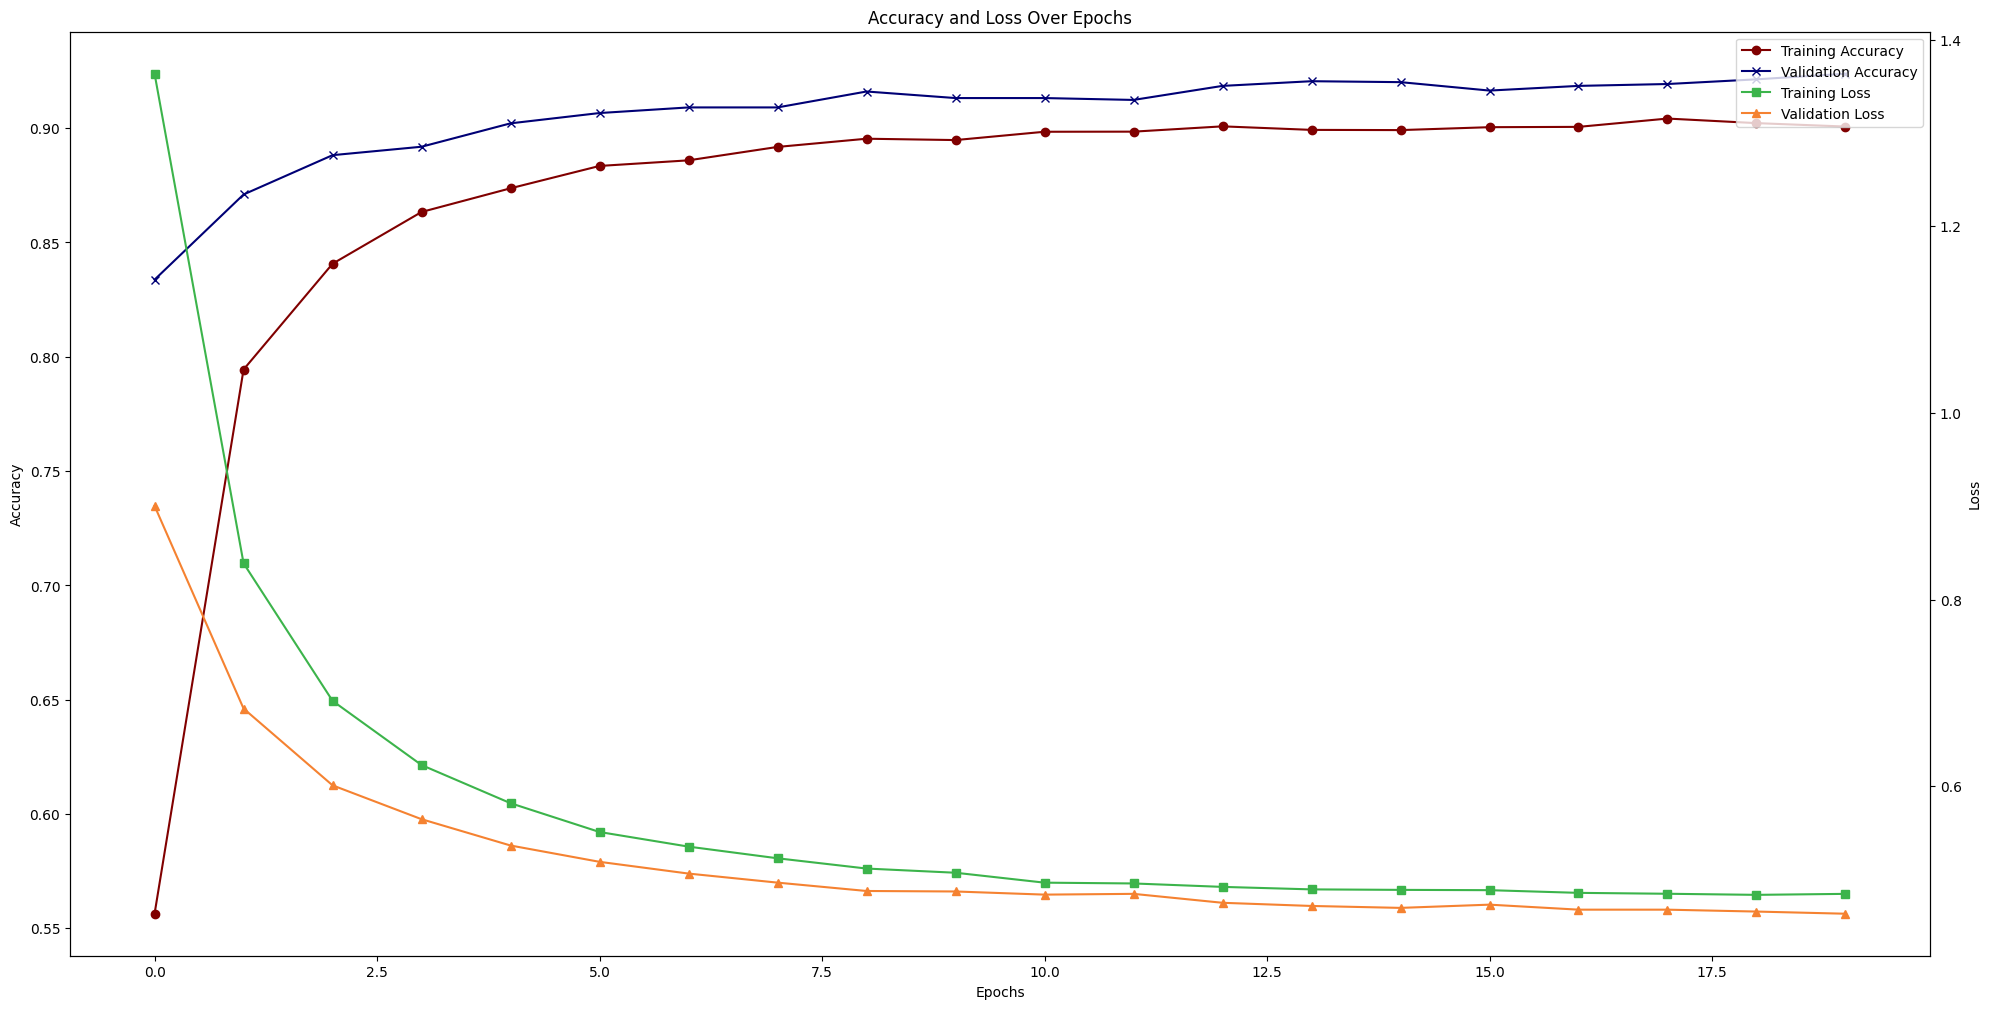

In [32]:
accuracy_loss_plot(history, 'without_tuning')

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
print(val_acc)


[0.5563687682151794, 0.7944358587265015, 0.8407127857208252, 0.8633512258529663, 0.8737158179283142, 0.8834894299507141, 0.8859441876411438, 0.8918083310127258, 0.8953995704650879, 0.8948085904121399, 0.8984453082084656, 0.8984907865524292, 0.9008091688156128, 0.8992635607719421, 0.8991726636886597, 0.9004455208778381, 0.9005818963050842, 0.9042185544967651, 0.9022184014320374, 0.9007182717323303]
[0.8337428569793701, 0.8710073828697205, 0.8882063627243042, 0.8918918967247009, 0.9021294116973877, 0.9066339135169983, 0.9090909361839294, 0.9090909361839294, 0.9160524010658264, 0.9131858944892883, 0.9131858944892883, 0.9123669266700745, 0.9185094237327576, 0.920556902885437, 0.9201474189758301, 0.9164619445800781, 0.9185094237327576, 0.9193283915519714, 0.9213759303092957, 0.9238329529762268]


In [34]:
#evaluating the model
accuracy0 = model.evaluate(validation_dataset)

77/77 [==============================] - 57s 724ms/step - loss: 0.4635 - accuracy: 0.9238 - top_k_categorical_accuracy: 0.8088


In [35]:

print("initial accuracy: {:.2f}".format(accuracy0[1]))

initial accuracy: 0.92


### Learning curves

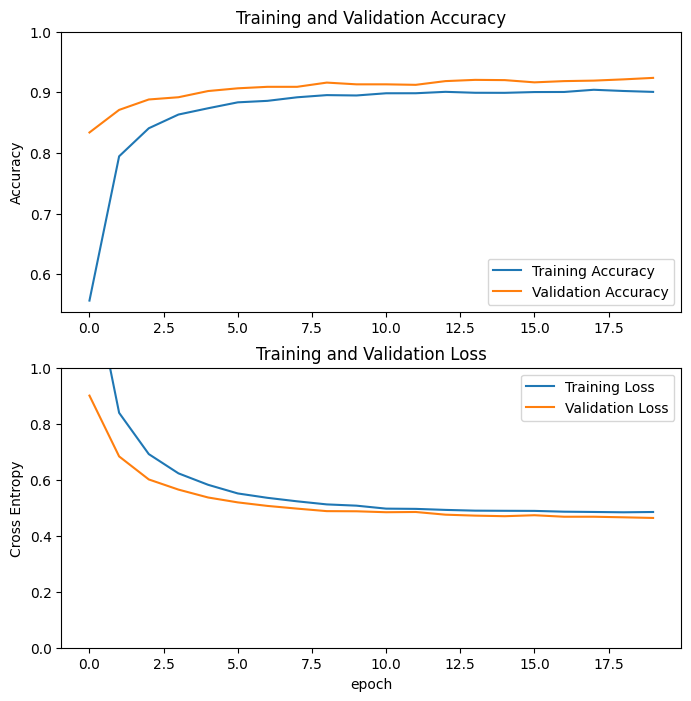

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [37]:
base_model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  270


### Compile the model

In [39]:

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])


In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 prediction (Dense)          (None, 6)                 7686  

In [41]:
len(model.trainable_variables)

151

### Continue training the model

In [42]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


688/688 [==============================] - 1332s 2s/step - loss: 0.3440 - accuracy: 0.9325 - top_k_categorical_accuracy: 0.8363 - val_loss: 0.2994 - val_accuracy: 0.9447 - val_top_k_categorical_accuracy: 0.7351
Epoch 21/40
688/688 [==============================] - 1277s 2s/step - loss: 0.2536 - accuracy: 0.9581 - top_k_categorical_accuracy: 0.7950 - val_loss: 0.2564 - val_accuracy: 0.9554 - val_top_k_categorical_accuracy: 0.7195
Epoch 22/40
688/688 [==============================] - 1276s 2s/step - loss: 0.2134 - accuracy: 0.9702 - top_k_categorical_accuracy: 0.7644 - val_loss: 0.2051 - val_accuracy: 0.9717 - val_top_k_categorical_accuracy: 0.6761
Epoch 23/40
688/688 [==============================] - 1278s 2s/step - loss: 0.1904 - accuracy: 0.9753 - top_k_categorical_accuracy: 0.7277 - val_loss: 0.1922 - val_accuracy: 0.9722 - val_top_k_categorical_accuracy: 0.6335
Epoch 24/40
688/688 [==============================] - 1292s 2s/step - loss: 0.1684 - accuracy: 0.9820 - top_k_categoric

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


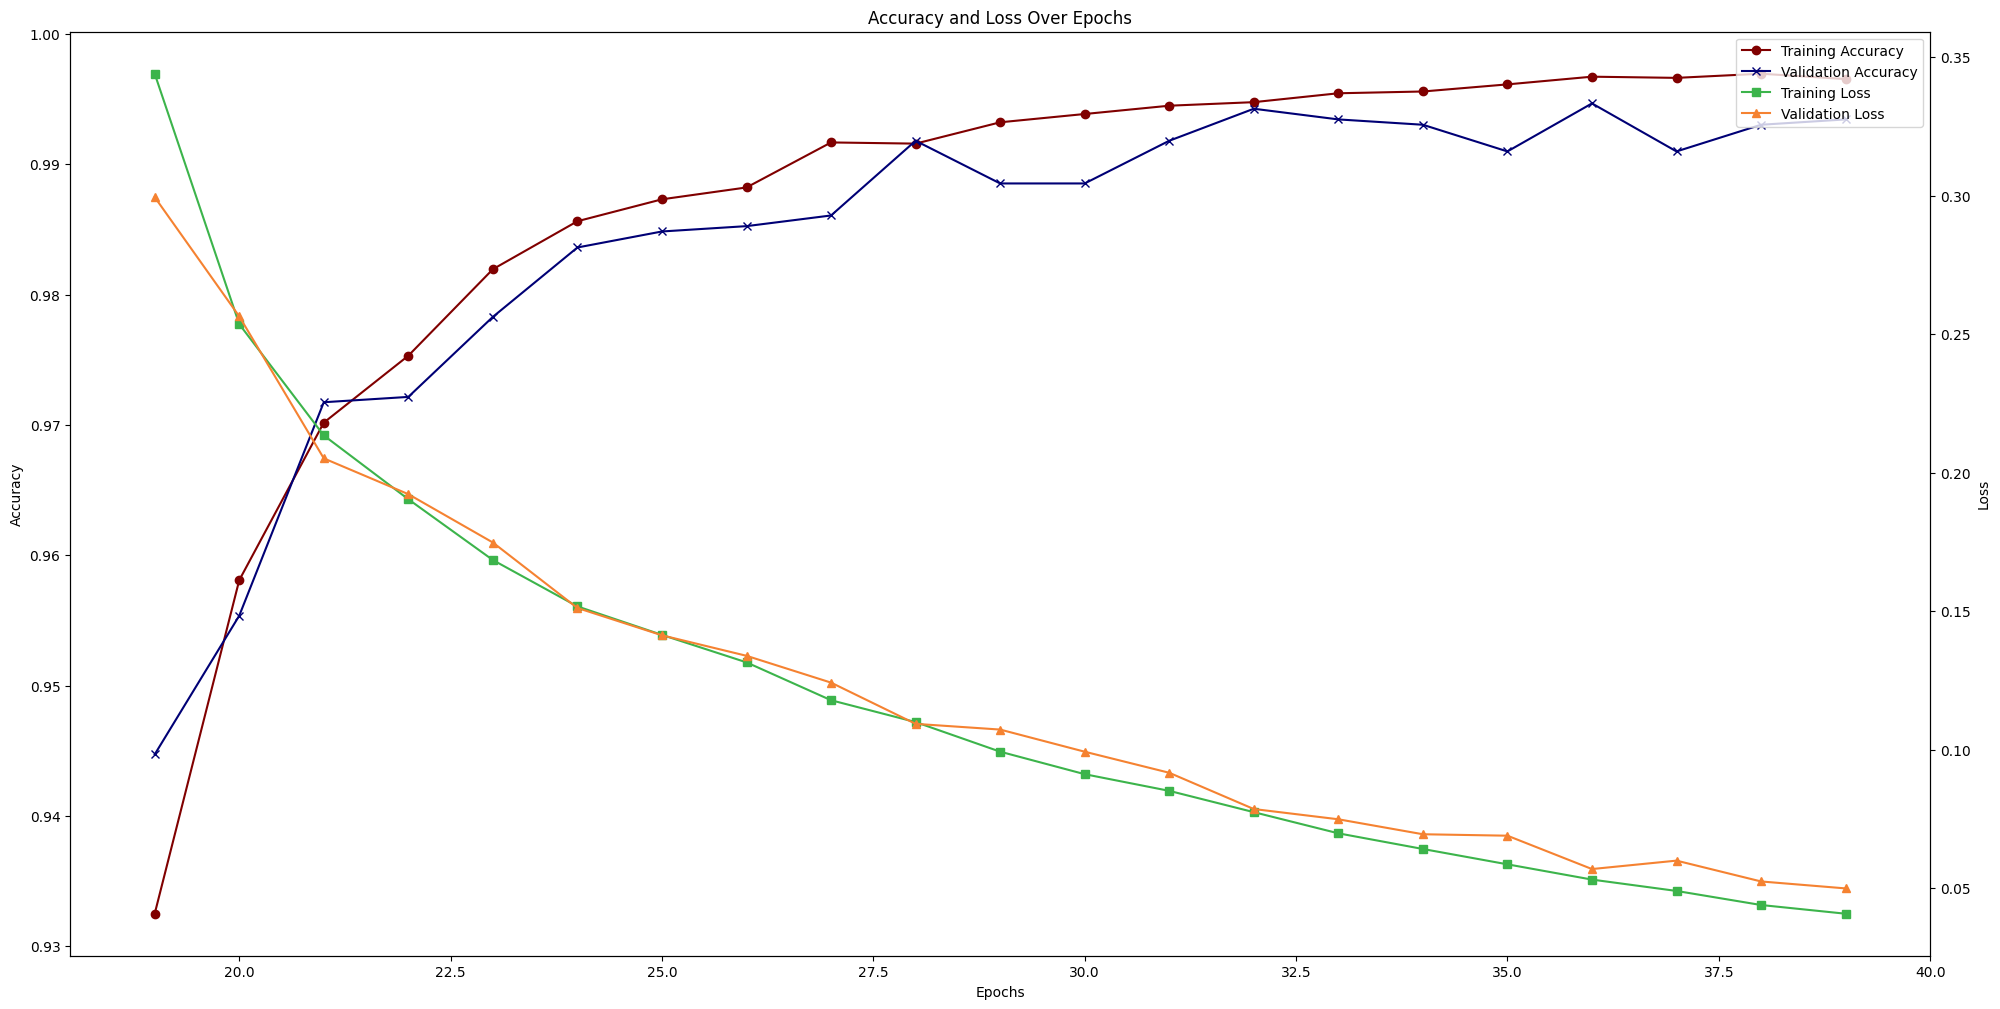

In [43]:
accuracy_loss_plot(history_fine, 'with_tuning')

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

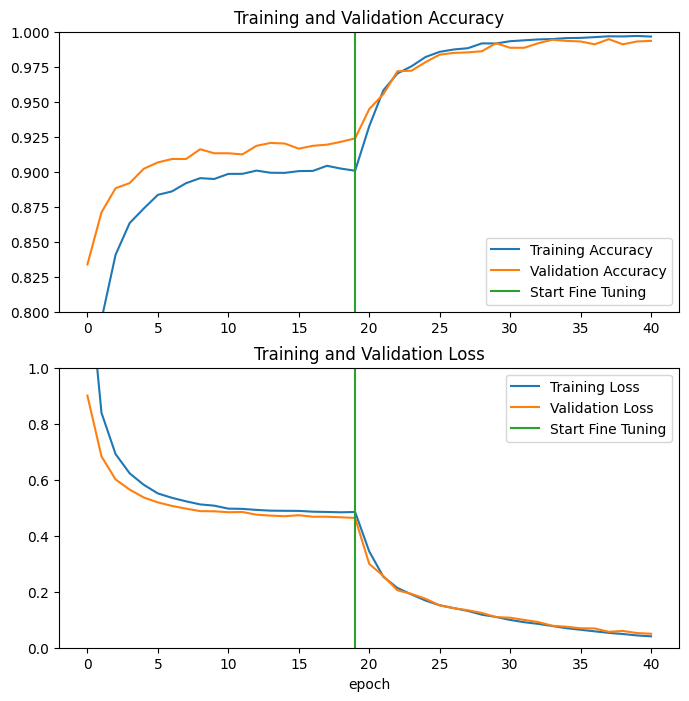

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [46]:
accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy[1])

19/19 [==============================] - 15s 784ms/step - loss: 0.2985 - accuracy: 0.9183 - top_k_categorical_accuracy: 0.8450
Test accuracy : 0.9183333516120911


In [47]:
# Get the predictions for the test data
predictions = model.predict(test_dataset)

19/19 [==============================] - 17s 728ms/step


Predicted Classes:
 [0 0 0 0 0 0 0 0 0 4 0 0 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4
 4 4 4 4 4 4 4 4 4 1 1 1 4 5 5 5 5 5 4 5 0 0 0 1 1 1 1 5 1 1 1 1 5 5 1 1 1
 1 1 3 1 1 1 1 1 1 1 5 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4
 4 4 

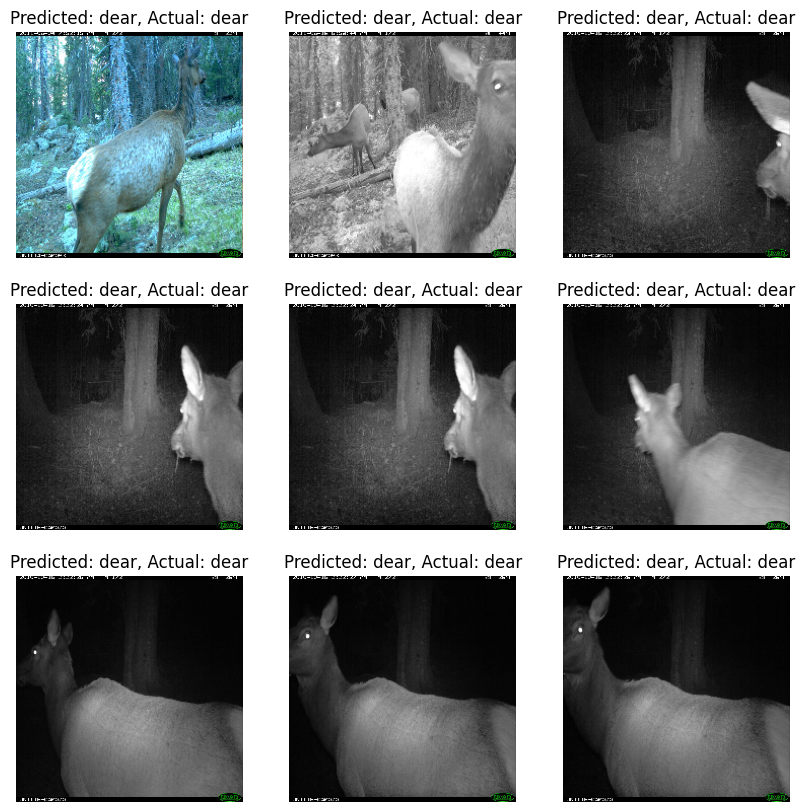

In [48]:

# Apply argmax to get the predicted class
predicted_classes = tf.argmax(predictions, axis=1)


print('Predicted Classes:\n', predicted_classes.numpy())
print('True Classes:\n', np.array(true_labels))

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Predicted: {class_labels[predicted_classes[i]]}, Actual: {class_labels[labels[i]]}')
    plt.axis("off")


In [49]:

from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


acc = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='macro')
recall = recall_score(true_labels, predicted_classes, average='macro')
f1 = f1_score(true_labels, predicted_classes, average='macro')

metrics_path = os.path.join(os.getcwd(), './metrics/metric_values')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{model_name}-metrics-{format(curr_datetime)}.txt'

if not os.path.exists(metrics_path):
    os.makedirs(metrics_path)

file_path = os.path.join(metrics_path, filename)
with open(file_path, 'w') as file:
    file.write(f'Accuracy: {acc:.3f}\n')
    file.write(f'Precision: {precision:.3f}\n')
    file.write(f'Recall: {recall:.3f}\n')
    file.write(f'F1 Score: {f1:.3f}\n')
  
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

Accuracy: 0.918
Precision: 0.929
Recall: 0.918
F1 Score: 0.917


In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix_res = confusion_matrix(true_labels, predicted_classes)


plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_res, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

confusion_matrix_path = os.path.join(os.getcwd(), './metrics_efficientnet/confusion_matrices')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{model_name}-confusion_matrix-{format(curr_datetime)}.png'

if not os.path.exists(confusion_matrix_path):
    os.makedirs(confusion_matrix_path)

# Save the plot to the specified folder
save_path = os.path.join(confusion_matrix_path, filename)
plt.savefig(save_path, bbox_inches='tight')

ModuleNotFoundError: No module named 'seaborn'

In [8]:
from datetime import datetime
from itertools import cycle
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, roc_curve

model_name = 'EfficientNetV2B0'
num_labels=6

def get_ROC_AUC(y_pred, y_target):
    # Binarize the labels
    n_classes = num_labels
    true_labels_bin = label_binarize(y_target, classes=range(n_classes))
    predicted_labels_bin = label_binarize(y_pred, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        print()
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def save_ROC_AUC(fpr, tpr, roc_auc):
    n_classes = num_labels

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 12))

    hex_colors = [
        "#FF0000",  # Red
        "#00FF00",  # Green
        "#0000FF",  # Blue
        "#FFFF00",  # Yellow
        "#FF00FF",  # Magenta
        "#00FFFF",  # Cyan
        "#FFA500",  # Orange
        "#FF4500",  # OrangeRed
        "#FFD700",  # Gold
        "#8A2BE2",  # BlueViolet
        "#7FFF00",  # Chartreuse
        "#DC143C",  # Crimson
        "#48D1CC",  # MediumTurquoise
        "#2E8B57",  # SeaGreen
        "#800080",  # Purple
        "#ADFF2F",  # GreenYellow
        "#FF1493",  # DeepPink
        "#9370DB",  # MediumPurple
        "#8B4513",  # SaddleBrown
        "#20B2AA",  # LightSeaGreen
        "#8B008B",  # DarkMagenta
        "#FF6347",  # Tomato
        "#556B2F",  # DarkOliveGreen
        "#6B8E23",  # OliveDrab
        "#BDB76B",  # DarkKhaki
        "#808080",  # Gray
        "#DAA520",  # GoldenRod
    ]

    colors = cycle(hex_colors)  # Adjust as needed for your number of classes

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve and AUC')
    plt.legend(loc='lower right')

    roc_auc_path = os.path.join(os.getcwd(), './metrics/roc_auc')
    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-roc_auc-{format(curr_datetime)}.png'

    if not os.path.exists(roc_auc_path):
        os.makedirs(roc_auc_path)

    # Save the plot to the specified folder
    save_path = os.path.join(roc_auc_path, filename)
    plt.savefig(save_path, bbox_inches='tight')

In [55]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes.numpy(),target_names = class_labels))

                precision    recall  f1-score   support

          dear       0.95      0.97      0.96       100
           fox       1.00      0.69      0.82       100
   leopard cat       1.00      0.99      0.99       100
     porcupine       0.98      1.00      0.99       100
sumatran serow       0.78      0.98      0.87       100
     wild boar       0.86      0.88      0.87       100

      accuracy                           0.92       600
     macro avg       0.93      0.92      0.92       600
  weighted avg       0.93      0.92      0.92       600


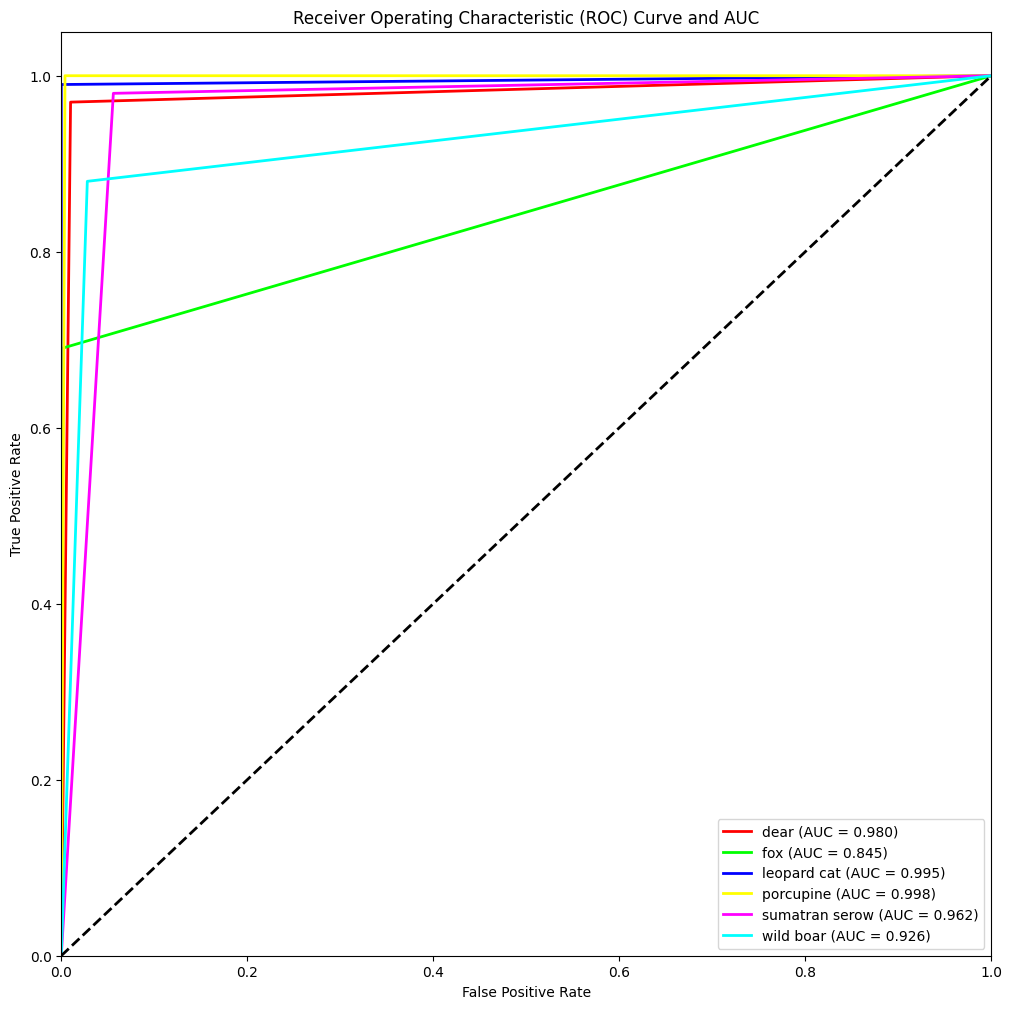

In [56]:
fpr, tpr, roc_auc = get_ROC_AUC(predicted_classes, true_labels)
save_ROC_AUC(fpr, tpr, roc_auc)

In [57]:
#save weights of the trained model to the specified folder
model.save_weights(os.path.join(model_save_dir, model_name + "_weights.h5"))

In [58]:
#save model to the specified folder
model.save(os.path.join(model_save_dir, model_name + ".h5"))

c:\Users\sumeela\FYP\Animal-Classification-at-Edge\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
#convert to tflite and save to new folder called tflite_models
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = os.path.join(os.getcwd(), 'tflite_models')
tflite_model_dir = os.path.join(tflite_models_dir, model_name)

if not os.path.exists(tflite_model_dir):
    os.makedirs(tflite_model_dir)

tflite_model_save_path = os.path.join(tflite_model_dir, model_name + ".tflite")
with open(tflite_model_save_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\sumeela\AppData\Local\Temp\tmpio04724w\assets


INFO:tensorflow:Assets written to: C:\Users\sumeela\AppData\Local\Temp\tmpio04724w\assets


In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Open image and resize
img_path = 'geranimo-AX9sJ-mPoL4-unsplash.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0  # Normalize pixel values to be between 0 and 1

# Load the model
model = tf.keras.models.load_model('models/EfficientNetV2B0/EfficientNetV2B0/EfficientNetV2B0.h5')

# Make predictions
predictions = model.predict(test_dataset)
print(predictions)

# Get the index of the highest probability class
predicted_class_index = np.argmax(predictions, axis=1)
print(predicted_class_index)

# You might have a class_names list, and you can print the predicted class name
# print(class_names[predicted_class_index[0]])


19/19 [==============================] - 38s 1s/step
[[9.95229483e-01 2.06538802e-03 2.63864640e-04 2.69833632e-04
  1.06341660e-03 1.10804569e-03]
 [9.25132453e-01 5.42487658e-04 1.42778981e-05 2.51951988e-05
  7.41109625e-02 1.74737797e-04]
 [9.99925613e-01 4.94827918e-06 9.69052252e-08 1.12519616e-09
  6.53472234e-05 3.96505766e-06]
 ...
 [5.46430692e-06 9.09217363e-07 4.51179943e-07 1.63081097e-06
  1.24697044e-01 8.75294507e-01]
 [2.58876589e-05 1.41784447e-04 4.11019164e-06 3.48587332e-06
  1.78880826e-01 8.20943952e-01]
 [1.74338641e-06 1.25697227e-06 3.18551088e-08 1.00758356e-07
  1.85249224e-02 9.81471896e-01]]
[0 0 0 0 0 0 0 0 0 4 0 0 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4
 4 4 4 4 4 4 4 4 4 1 1 1 4 5 5 5 5 5 4 5 0 0 0 1 1 1 1 5 1 1 1 1 5 5 1 

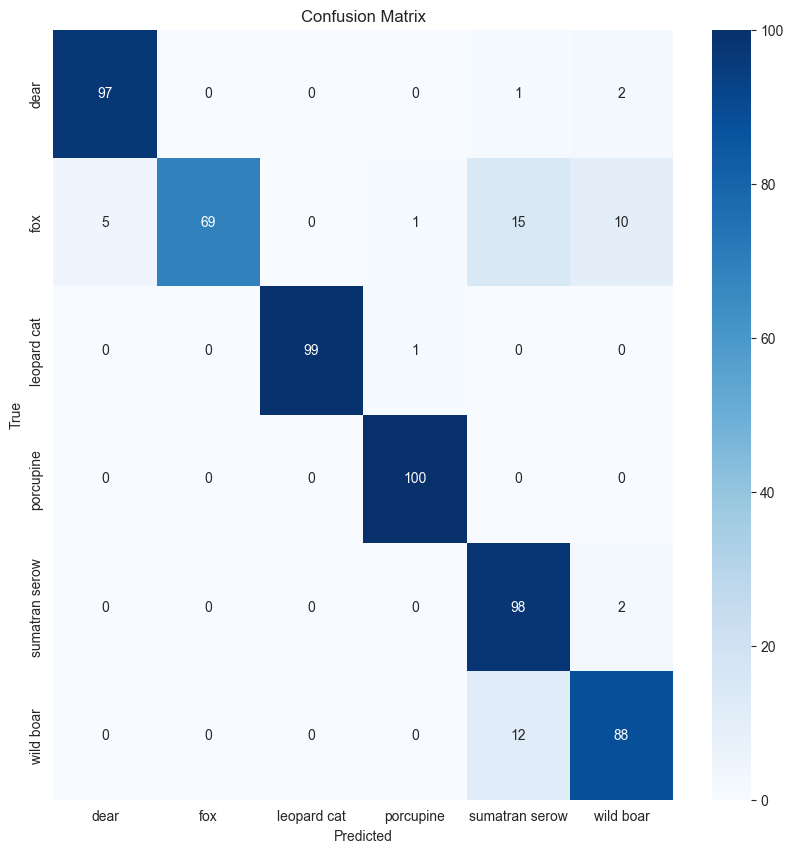

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix_res = confusion_matrix(true_labels, predicted_class_index)


plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_res, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

confusion_matrix_path = os.path.join(os.getcwd(), './metrics_efficientnet/confusion_matrices')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{model_name}-confusion_matrix-{format(curr_datetime)}.png'

if not os.path.exists(confusion_matrix_path):
    os.makedirs(confusion_matrix_path)

# Save the plot to the specified folder
save_path = os.path.join(confusion_matrix_path, filename)
plt.savefig(save_path, bbox_inches='tight')

In [61]:

# from sklearn.metrics import classification_report


# #load tf lite model and want to calculate accuracy of the compressed model
# interpreter = tf.lite.Interpreter(model_path='./tflite_models/MobileNetV2/MobileNetV2.tflite')

# true_labels = true_labels
# predicted_labels = []

# for images, labels in test_dataset:
#     for image in images:
#         image = tf.expand_dims(image, axis=0)
#         interpreter.allocate_tensors()
#         interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image)
#         interpreter.invoke()
#         preds = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
#         preds = np.argmax(preds, axis=1)
#         predicted_labels.extend(preds)

# print(classification_report(true_labels, predicted_labels, target_names=class_labels))


